c:\Users\harsh\miniconda3\envs\ml-depth-pro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Loaded image with size: 2688x1512


C:\Users\harsh\AppData\Local\Temp\ipykernel_8708\3152334568.py:54: UserWarning: WARNING: Image resolution is 2688x1512, but focal length 3131px was estimated for 4032x3024. The calculated absolute depth scale may be inaccurate. Consider adjusting KNOWN_FOCAL_LENGTH_PIXELS proportionally or using an image at the target resolution.
  warnings.warn(


Relative depth map generated.

--- Reference Object Selection ---
Draw a rectangle around the object whose real-world width is 0.0856m.
Press ENTER or SPACE after drawing the rectangle.
Press 'c' to cancel.
Selected ROI: x=248, y=907, width=644, height=328
Measured object width in image: 644 pixels
Median relative depth of the object: 1763.9294
Calculated Scale Factor: 734.0948
Estimated distance to the reference object: 0.42 meters


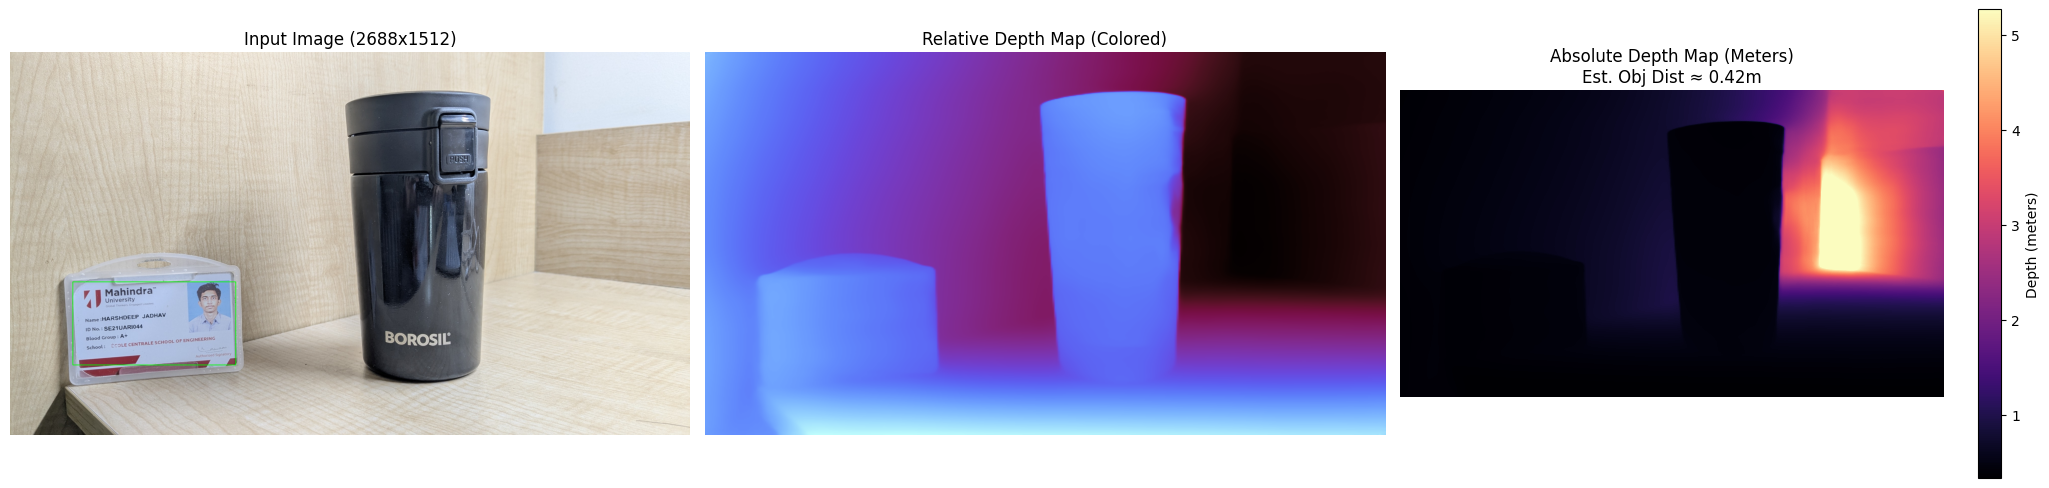

Absolute depth estimation using known object size complete.


In [1]:
import cv2
import torch
import numpy as np
import requests
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import warnings

# --- Configuration ---
MODEL_NAME = "Intel/dpt-hybrid-midas" # "Intel/dpt-large" Or "Intel/dpt-hybrid-midas", etc.
IMAGE_PATH = r"C:\Users\harsh\Downloads\PXL_20250418_052835918.jpg" # <-- CHANGE THIS - Needs an image from Pixel 6a with the reference object

# --- User Inputs (CRITICAL!) ---

# 1. Camera Focal Length (in pixels) - ESTIMATED for Pixel 6a Main Camera (IMX363)
#    *** IMPORTANT: This assumes image was taken at 4032x3024 resolution! ***
#    *** If your image resolution is different, this value needs adjustment. ***
#    *** For best results, perform camera calibration. ***
KNOWN_FOCAL_LENGTH_PIXELS = 3131 # <--- Estimated fx for Pixel 6a main camera @ 4032px width

# 2. Reference Object Real-World Size (in meters)
#    Using standard Credit Card Width as default
KNOWN_OBJECT_WIDTH_METERS = 0.0856 # Standard ID-1 card width
# KNOWN_OBJECT_HEIGHT_METERS = 0.05398 # Standard ID-1 card height
# Choose ONE dimension consistently (either width or height) and measure that in the ROI selection step.

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Model and Processor ---
try:
    processor = DPTImageProcessor.from_pretrained(MODEL_NAME)
    model = DPTForDepthEstimation.from_pretrained(MODEL_NAME)
    model.to(device)
    model.eval() # Set model to evaluation mode
except Exception as e:
    print(f"Error loading model/processor: {e}")
    exit()

# --- Load Image ---
try:
    if 'IMAGE_PATH' in locals() and IMAGE_PATH:
        image_pil = Image.open(IMAGE_PATH).convert("RGB")
    else:
        raise ValueError("No image path specified")

    original_width, original_height = image_pil.size
    image_display_bgr = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR) # OpenCV uses BGR
    print(f"Loaded image with size: {original_width}x{original_height}")
    # --- Verification ---
    if original_width != 4032 or original_height != 3024:
        warnings.warn(
            f"WARNING: Image resolution is {original_width}x{original_height}, "
            f"but focal length {KNOWN_FOCAL_LENGTH_PIXELS}px was estimated for 4032x3024. "
            f"The calculated absolute depth scale may be inaccurate. "
            f"Consider adjusting KNOWN_FOCAL_LENGTH_PIXELS proportionally "
            f"or using an image at the target resolution.", UserWarning
            )

except FileNotFoundError:
    print(f"Error: Image file not found at {IMAGE_PATH}")
    exit()
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

# --- Prepare Image for Model ---
inputs = processor(images=image_pil, return_tensors="pt")
pixel_values = inputs.pixel_values.to(device)

# --- Perform Inference (Get Relative Depth) ---
with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

# --- Post-process Relative Depth ---
prediction_resized = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image_pil.size[::-1], # (height, width)
    mode="bilinear",
    align_corners=False,
)
relative_depth_map = prediction_resized.squeeze().cpu().numpy()
print("Relative depth map generated.")

# --- Select Reference Object ROI (Region of Interest) ---
print("\n--- Reference Object Selection ---")
print(f"Draw a rectangle around the object whose real-world width is {KNOWN_OBJECT_WIDTH_METERS}m.")
print("Press ENTER or SPACE after drawing the rectangle.")
print("Press 'c' to cancel.")

cv2.namedWindow("Select Reference Object", cv2.WINDOW_NORMAL)
# Adjust window size for better viewing if needed
preview_width = min(1280, original_width)
preview_height = int(preview_width * (original_height / original_width))
cv2.resizeWindow("Select Reference Object", preview_width, preview_height)

roi = cv2.selectROI("Select Reference Object", image_display_bgr, fromCenter=False, showCrosshair=True)
cv2.destroyWindow("Select Reference Object")

if roi == (0, 0, 0, 0): # Check if selection was cancelled or invalid
    print("ROI selection cancelled or invalid. Exiting.")
    exit()

x, y, w, h = roi
print(f"Selected ROI: x={x}, y={y}, width={w}, height={h}")

if w == 0 or h == 0:
     print("Selected ROI has zero width or height. Exiting.")
     exit()

# --- Extract Information from ROI ---

# 1. Measure Object Size in Pixels (Using ROI width here, matching KNOWN_OBJECT_WIDTH_METERS)
object_size_pixels = w
print(f"Measured object width in image: {object_size_pixels} pixels")
if object_size_pixels <= 0:
    print("Error: Object size in pixels is zero or negative.")
    exit()

# 2. Get Average Relative Depth within the ROI
roi_depth = relative_depth_map[y:y+h, x:x+w]
if roi_depth.size == 0:
    print("Error: Could not extract depth values from the ROI. Is ROI valid?")
    exit()

d_relative_object = np.median(roi_depth)
print(f"Median relative depth of the object: {d_relative_object:.4f}")

if d_relative_object <= 1e-6:
    print("Error: Relative depth of the object is too small or zero.")
    exit()

# --- Calculate Scale Factor ---
# Scale_Factor ≈ (Size_real * focal_length_pixels * d_relative) / size_pixels
scale_factor = (KNOWN_OBJECT_WIDTH_METERS * KNOWN_FOCAL_LENGTH_PIXELS * d_relative_object) / object_size_pixels
print(f"Calculated Scale Factor: {scale_factor:.4f}")

# --- Estimate Distance to Object (for verification) ---
estimated_distance = scale_factor / d_relative_object
print(f"Estimated distance to the reference object: {estimated_distance:.2f} meters")

# --- Calculate Absolute Depth Map ---
epsilon = 1e-6 # Avoid division by zero
absolute_depth_map = scale_factor / (relative_depth_map + epsilon)
absolute_depth_map[absolute_depth_map <= 0] = np.median(absolute_depth_map[absolute_depth_map > 0]) # Replace non-positives

# --- Visualize Results ---
relative_depth_visual = cv2.normalize(relative_depth_map, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
relative_depth_colored = cv2.applyColorMap(relative_depth_visual, cv2.COLORMAP_MAGMA)

min_depth_vis = np.percentile(absolute_depth_map[absolute_depth_map > 0], 2)
max_depth_vis = np.percentile(absolute_depth_map[absolute_depth_map > 0], 98)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

image_display_rgb = cv2.cvtColor(image_display_bgr, cv2.COLOR_BGR2RGB)
cv2.rectangle(image_display_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
ax[0].imshow(image_display_rgb)
ax[0].set_title(f"Input Image ({original_width}x{original_height})")
ax[0].axis('off')

ax[1].imshow(relative_depth_colored)
ax[1].set_title("Relative Depth Map (Colored)")
ax[1].axis('off')

im = ax[2].imshow(absolute_depth_map, cmap='magma', vmin=min_depth_vis, vmax=max_depth_vis)
ax[2].set_title(f"Absolute Depth Map (Meters)\nEst. Obj Dist ≈ {estimated_distance:.2f}m")
ax[2].axis('off')
cbar = fig.colorbar(im, ax=ax[2], shrink=0.7)
cbar.set_label('Depth (meters)')

plt.tight_layout()
plt.show()

print("Absolute depth estimation using known object size complete.")